In [ ]:
## LSTM - WindMills - single step model
'''Точечное прогнозирование. В данном случае модель обучается прогнозированию одного значения в будущем 
на основе имеющейся истории.
https://habr.com/ru/post/495884/'''

In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Importing the dataset
wme = pd.read_csv('WindMills.csv')
wma = pd.read_csv('WindMillsActual.csv')
wm = pd.merge(wma, wme, on='Time')

C:\Users\kater\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (3,12,13,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
wma

,Time,Wind_direction,Temperature,Pressure,Humidity
0,1/1/2016 0:00,101.0,1.3,885.9,65.4
1,1/1/2016 0:15,98.1,1.3,885.7,67.2
2,1/1/2016 0:30,99.8,1.2,885.6,68.1
3,1/1/2016 0:45,102.4,1.2,885.5,68.8
4,1/1/2016 1:00,102.8,1.2,885.3,70.1
...,...,...,...,...,...
70172,12/31/2017 23:00,63.4,2.1,885.5,45.2
70173,12/31/2017 23:15,75.9,2.0,885.3,45.5
70174,12/31/2017 23:30,69.4,2.1,885.3,45.8
70175,12/31/2017 23:45,72.9,2.0,885.2,46.2


In [4]:
# Checking missing
total = wma.isnull().sum().sort_values(ascending=False)
percent = (wma.isnull().sum()/wma.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
Wind_direction,33067,0.471194
Humidity,33050,0.470952
Pressure,33007,0.470339
Temperature,33004,0.470297
Time,0,0.000000


In [3]:
wma = wma.dropna()

In [4]:
# Features 
features_considered = ['Wind_direction','Temperature','Humidity']
features = wma[features_considered]
features.index = wma['Time']
features.head()

,Wind_direction,Temperature,Humidity
Time,,,
1/1/2016 0:00,101.0,1.3,65.4
1/1/2016 0:15,98.1,1.3,67.2
1/1/2016 0:30,99.8,1.2,68.1
1/1/2016 0:45,102.4,1.2,68.8
1/1/2016 1:00,102.8,1.2,70.1


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000025D1BCD2F88>,
      dtype=object)

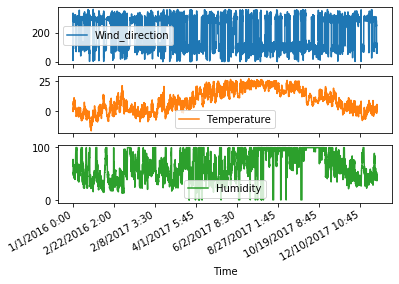

In [7]:
# Plotting data
features.plot(subplots=True)

In [5]:
'''Подготовим данные для модели с многомерным входом.'''
dataset = features.values

'''Первые 30 000 строк данных будут использоваться для обучения модели, оставшиеся – для её валидации (проверки). 
В этом случае объём обучающих данных составляет примерно 313 дней.'''
# Splitting dataset
TRAIN_SPLIT = 30000
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

'''Стандартизация должна выполняться только c использованием обучающих данных.'''
dataset = (dataset-data_mean)/data_std

In [6]:
'''Точечное прогнозирование. В данном случае модель обучается прогнозированию одного значения в будущем 
на основе имеющейся истории.
Приведенная функция выполняет задачу организации временных интервалов, отбирая последние наблюдения 
на основе заданного размера шага.'''
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [7]:
'''ИНС оперирует данными за последние пять (5) дней, то есть 480 наблюдениями (4х24х5). 
Допустим, что отбор данных проводится не каждые 15 минут, а каждый час: 
в течение 60 минут резкие изменения не ожидаются. 
Следовательно, историю последних пяти дней составляют 120 наблюдений (480/4). 
Для модели, выполняющей точечное прогнозирование, целью является значение температуры через 12 часов в будущем. 
В этом случае целевой вектор будет составлять температура после 48 (12х4) наблюдений'''
# Creating lagged dataset
past_history = 480
future_target = 48
STEP = 4

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [10]:
'''Проверим временной интервал'''
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


In [8]:
# Importing the Tensorflow libraries and packages
import tensorflow as tf
#from tf.data import Dataset

# Importing the Keras libraries and packages
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

C:\Users\kater\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\kater\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\kater\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\kater\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [9]:
'''C помощью tf.data выполним перемешивание (shuffle), пакетирование (batch) и кэширование (cache) набора данных.'''
# Data preprocessing
BATCH_SIZE = 128
BUFFER_SIZE = 100

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [10]:
# LSTM creating
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(12,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [14]:
'''Проверим выборку'''
single_step_model.predict(val_data_single.take(1)).shape

(128, 1)

In [11]:
'''Обучим модель и  выведем кривые потерь на этапах обучения и проверки'''
# Fitting
EVALUATION_INTERVAL = 50
EPOCHS = 10
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
50/50 [==============================] - 9s 182ms/step - loss: 1.0144 - val_loss: 0.4406
Epoch 2/10
50/50 [==============================] - 6s 127ms/step - loss: 0.4183 - val_loss: 0.3454
Epoch 3/10
50/50 [==============================] - 6s 129ms/step - loss: 0.5245 - val_loss: 0.3470
Epoch 4/10
50/50 [==============================] - 6s 130ms/step - loss: 0.2689 - val_loss: 0.3362
Epoch 5/10
50/50 [==============================] - 6s 126ms/step - loss: 0.2904 - val_loss: 0.3100
Epoch 6/10
50/50 [==============================] - 6s 125ms/step - loss: 0.3058 - val_loss: 0.2922
Epoch 7/10
50/50 [==============================] - 6s 125ms/step - loss: 0.3240 - val_loss: 0.2892
Epoch 8/10
50/50 [==============================] - 6s 124ms/step - loss: 0.3036 - val_loss: 0.3360
Epoch 9/10
50/50 [==============================] - 6s 123ms/step - loss: 0.2004 - val_loss: 0.3308
Epoch 

In [12]:
# Plotting history function
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

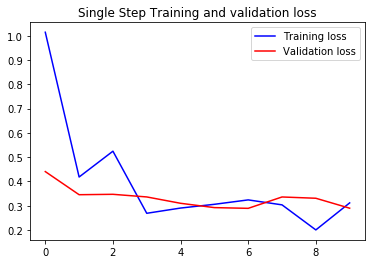

In [13]:
# Plotting history
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

In [16]:
def create_time_steps(length):
  return list(range(-length, 0))

In [17]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

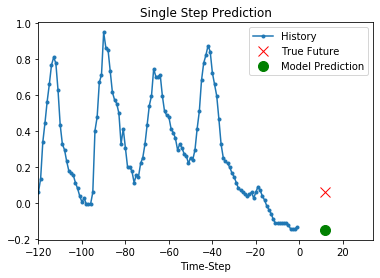

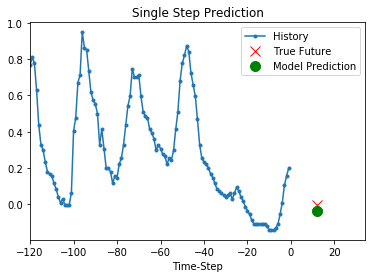

In [27]:
'''Выполнение точечного прогноза.
Когда модель обучена, выполним несколько пробных прогнозов. 
На вход модели подаётся история наблюдений 2-х признаков за последние пять дней, 
отобранных каждый час (временной интервал = 120). 
Так как цель заключается в прогнозе только температуры, синим цветом на графике отображены прошлые значения температуры 
(история). Прогноз выполнен на полдня в будущее (отсюда разрыв между историей и спрогнозированным значением).'''
# LSTM Prediction plotting
for i in range(0,47,24):
    plot = show_plot([x_val_single[i][:, 1], y_val_single[i], single_step_model.predict(val_data_single.take(3))[i]], 12,
           'Single Step Prediction')
    plot.show()